In [2]:
%reset -fs

In [3]:
import pandas as pd
import xgboost
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [7]:
#, index_col=0
diamond_df = pd.read_csv('diamonds.csv')

In [8]:
diamond_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [9]:
diamond_df.shape

(53940, 10)

In [10]:
diamond_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [11]:
diamond_df.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

In [12]:
# Encode the ordinal categorical variable 'cut'
cut_mapping = {'Fair': 0, 'Good': 1, 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
diamond_df.cut = diamond_df.cut.map(cut_mapping)

In [13]:
diamond_df.color.value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

In [14]:
# Encoding the ordinal categorical variable 'color'
color_mapping = {'J': 0, 'I': 1, 'H': 2, 'G': 3, 'F': 4, 'E': 5, 'D': 6}
diamond_df.color = diamond_df.color.map(color_mapping)

In [15]:
diamond_df.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

In [16]:
# Encoding the ordinal cateogircal variable 'clarity'
clarity_mapping = {'I1': 0, 'SI2': 1, 'SI1': 2, 'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
diamond_df.clarity = diamond_df.clarity.map(clarity_mapping)

In [17]:
diamond_df.describe()

,carat,cut,color,clarity,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,2.904097,3.405803,3.051020,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.116600,1.701105,1.647136,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,0.000000,0.000000,0.000000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,2.000000,2.000000,2.000000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,3.000000,3.000000,3.000000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,4.000000,5.000000,4.000000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,4.000000,6.000000,7.000000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [18]:
diamond_df = diamond_df.drop(diamond_df[diamond_df["x"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["y"]==0].index)
diamond_df = diamond_df.drop(diamond_df[diamond_df["z"]==0].index)

In [19]:
diamond_df = diamond_df[diamond_df['depth'] < diamond_df['depth'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['table'] < diamond_df['table'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['x'] < diamond_df['x'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['y'] < diamond_df['y'].quantile(0.99)]
diamond_df = diamond_df[diamond_df['z'] < diamond_df['z'].quantile(0.99)]

In [20]:
model_df = diamond_df.copy()

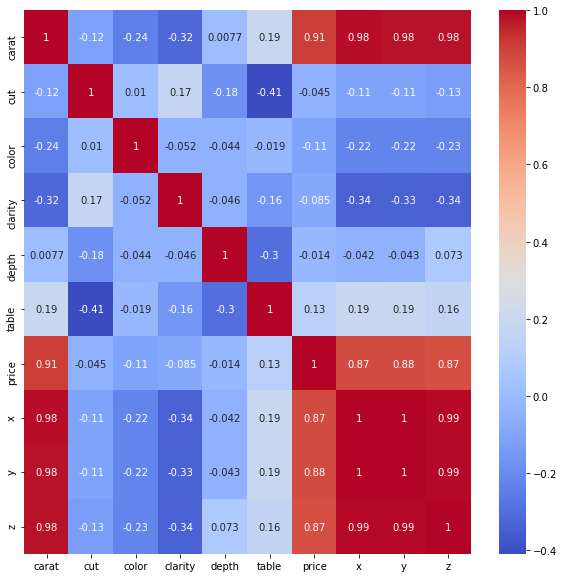

In [21]:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(model_df.corr(), annot=True, cmap='coolwarm');

In [22]:
X = model_df.drop(['price'], axis=1)
y = model_df['price']

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=0)

xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'],
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'min_child_weight': [3,5,7],
              'subsample': [0.1,0.5,1.0],
              'colsample_bytree': [0.1, 0.5, 1.0],
              'n_estimators': [500]}

In [25]:
xgb1 = XGBRegressor()
parameters = {
              'objective':['reg:squarederror'], 
              'learning_rate': [.0001, 0.001, .01],
              'max_depth': [3, 5, 7],
              'n_estimators': [500]}

In [26]:
xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 3,
                        n_jobs = -1,
                        verbose=0)

In [28]:
xgb_grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat...None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01],
                         'max_depth': [3, 5, 7], 'n_estimators': [500],
                         'objective': ['reg:squarederror']})

In [29]:
print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

0.9828837315352444
{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'objective': 'reg:squarederror'}


In [30]:
xgb_cv = (xgb_grid.best_estimator_)

In [31]:
eval_set = [(X_train, y_train),
            (X_val, y_val)]

In [32]:
fit_model = xgb_cv.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    eval_metric='mae',
    early_stopping_rounds=50,
    verbose=False)

C:\Users\dell\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\dell\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [33]:
print("MAE:", mean_absolute_error(y_val, fit_model.predict(X_val)))
print("MSE:", mean_squared_error(y_val, fit_model.predict(X_val)))
print("R2:", r2_score(y_val, fit_model.predict(X_val)))

MAE: 237.89164740750638
MSE: 200787.1969296989
R2: 0.9831525989293243


In [34]:
print("MAE:", mean_absolute_error(y_test, fit_model.predict(X_test)))
print("MSE:", mean_squared_error(y_test, fit_model.predict(X_test)))
print("R2:", r2_score(y_test, fit_model.predict(X_test)))

MAE: 231.0056814323916
MSE: 180884.82139713512
R2: 0.9848929985628055


In [35]:
fit_model.save_model('xgb_model.json')